In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from numba import cuda
import numba
import time
import multiprocessing as mp
import matplotlib.font_manager as font_manager
import sys
from tqdm import tqdm

In [2]:
@jit(nopython = True)
def decide_interact_neuron_square(neuron_row, neuron_column, neuron_number_row, neuron_number_column):
    if (neuron_row - 1 < 0):
        left = [neuron_number_row -1, neuron_column]
    else:
        left = [neuron_row - 1, neuron_column]
    
    if (neuron_row + 1 == neuron_number_row):
        right = [0, neuron_column]
    else:
        right = [neuron_row + 1, neuron_column]
        
    if (neuron_column + 1 == neuron_number_column):
        up = [neuron_row, 0]
    else:
        up = [neuron_row, neuron_column + 1]
        
    if (neuron_column - 1 < 0):
        down = [neuron_row, neuron_number_column -1]
    else:
        down = [neuron_row, neuron_column - 1]
        
    return np.array([left, down, right, up])

@jit(nopython = True)
def create_square_lattice_link(row_number, column_number, sigma):
    square_lattice = np.zeros((row_number, column_number, 4, 2))
    p_max = 2*sigma/4
    flag = np.zeros((row_number, column_number , 4))
    link = np.zeros((row_number, column_number, 4))
    for row in range(row_number):
        for column in range(column_number):
            square_lattice[row][column][:] = decide_interact_neuron_square(row, column, row_number, column_number)[:]
            for i in range(4):
                if (flag[row][column][i] == 0):
                    random = p_max/2
#                     random = np.random.random() * p_max
                    link[row][column][i] = random
                    r, c = square_lattice[row][column][i]
                    link[int(r)][int(c)][int((i+2)%4)] = random
                    flag[row][column][i] = 1
                    flag[int(r)][int(c)][int((i+2)%4)] = 1
                    
    ###   break the periodic structure   ###
    # for c in range (column_number):
    #     link[0][c][0] = 0
    #     link[row_number - 1][c][2] = 0
    # for r in range (row_number):
    #     link[r][0][1] = 0
    #     link[r][column_number - 1][3] = 0
    return square_lattice, link

In [3]:
@jit(nopython = True)
def sigma_check(p):
    total = 0
    sigma = np.zeros((p.shape[0]*p.shape[1]))
    for i in range(p.shape[0]):
        for j in range(p.shape[1]):
            sigma[j+i*p.shape[1]] = p[i][j].sum()
            total += p[i][j].sum() / p.shape[0] / p.shape[1]
    return sigma, total

1.7999999999970777


Text(0.5, 1.0, '$\\sigma_i$ vs $N(\\sigma_i)$')

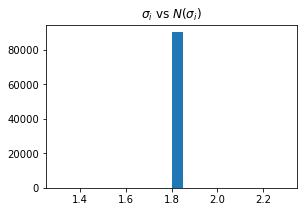

In [4]:
test_lattice, test_link = create_square_lattice_link(300,300,1.8)
sigma_link, total = sigma_check(test_link)
print(total)
fig, ax = plt.subplots(figsize=(4.5, 3))
plt.hist(sigma_link,20)
plt.title('$\sigma_i$ vs $N(\sigma_i)$')

In [5]:
###   external stimulus   ###
@jit(nopython = True)
def external_arr(t_min, t_max, t, r):
    if t_min <= t < t_max:
        return (1 - np.exp(-r))
    else:
        return np.zeros(r.shape)

###   internal(neural) stimulus   ###
@jit(nopython = True)
def internal_arr(p, index_matrix, state_matrix, state_number, degree):
    probability = np.zeros((state_matrix.shape))
    for row in range(state_matrix.shape[0]):
        for column in range(state_matrix.shape[1]):
            for i in range (int(degree[row][column])) :
                r, c = index_matrix[row][column][i]
#                 if (state_matrix[int(r)][int(c)] == 1):
                if (state_matrix[int(r)][int(c)] ==(state_number - 1) ):
                    probability[row][column] = 1 - (1 - p[row][column][i]) * (1 - probability[row][column])
    return probability

###   determine the activity   ###
@jit(nopython = True)
def rho_determine(state_matrix, state_number):
    row_number = state_matrix.shape[0]
    column_number = state_matrix.shape[1]
    fire = 0
    for row in range(row_number):
#         active = [i for i, v in enumerate(state_matrix[row]) if v==1]
        active = [i for i, v in enumerate(state_matrix[row]) if v == (state_number - 1)]
        fire += len(active)
    return fire/(state_matrix.shape[0]*state_matrix.shape[1])

###   determine the average activity   ###
@jit(nopython = True)
def F0_determine(rho, T_min = 0, T_max = 1000):
    return rho[T_min:T_max].sum()/rho[T_min:T_max].size


In [6]:
@jit(nopython = True)
def KC_model(degree, index_matrix, p, t_min, stimulas_t, stimulas_S, MC_times, state_number, noise_r = 0):
    
    ###   Initialization start   ###
    rho = np.zeros(MC_times)
    row_number = p.shape[0]
    column_number = p.shape[1]
    state_matrix = np.random.randint(0, state_number, (row_number, column_number))
#     state_matrix = np.zeros((row_number, column_number))
    rho[0] = rho_determine(state_matrix, state_number)
    temp = np.copy(state_matrix)
    
        
    ###   Monte Carlo   ###
    for t in range(1, MC_times):
        internal = internal_arr(p, index_matrix, state_matrix, state_number, degree)
        noise_array = 1 - np.exp(-np.random.random(size = (row_number, column_number)) * noise_r)
        
        ###   update states among per row direction   ###
        for r in range (row_number):
            
            ###   Update refractory state   ###
            loc = np.where((state_matrix[r]>0)&(state_matrix[r]<(state_number)))
            temp[r][loc] -= 1 
            
            ###   Locate the excitable neurons   ###
            location_0 = np.where(state_matrix[r] == 0)
            probability = np.zeros(column_number)
            probability[location_0] = 1 -  ((1 - internal[r][location_0]) * (1 - noise_array[r][location_0])*\
                                        (1 - external_arr(t_min, stimulas_t, t, stimulas_S[r][location_0])))
            
             ###   determine the process from resting to firing   ###
            random = np.random.random(column_number)
            temp[r][np.where(random < probability)] = state_number - 1
            
        state_matrix = np.copy(temp)
        rho[t] = rho_determine(state_matrix, state_number)
    return rho

Time cost: 18.708227157592773


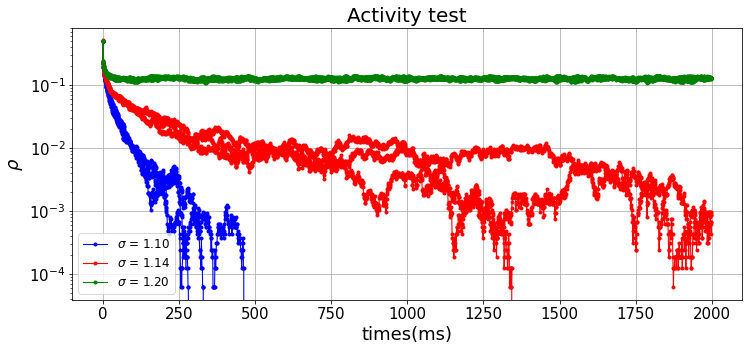

In [7]:
row = 128
column = 128
states_num = 2
color = ['blue', 'red', 'green']
r_list = [10**(-5), 10**(-6)]
sigma_list = [1.1, 1.14, 1.2]
times = 2000
fig, ax = plt.subplots(figsize=(12, 5))
t_test = np.arange(times)
start_i = time.time()
for i in range (9):
    sigma = sigma_list[i//3]
#     sigma = 1.9
    degree = np.ones((row, column))*4
    network_connection, p  = create_square_lattice_link(row,column,sigma)
    r = 0 #r_list[i]
    r_array = np.ones((row, column)) * r 
    rho_test = KC_model(degree, network_connection, p, 0, times, r_array, times, states_num)
    if(i%3):
        ax.plot(t_test[0:], rho_test[0:],'.' , linewidth=1.1, color = color[i//3], linestyle='-')
    else:
        ax.plot(t_test[0:], rho_test[0:],'.' , linewidth=1.1, color = color[i//3], linestyle='-', label = '$\sigma$ = %.2f'%sigma)
print('Time cost:', time.time()-start_i)
ax.set_yscale('log')
ax.set_xlabel('times(ms)',fontsize=18)
ax.set_ylabel('$\\rho$',fontsize=18)
# ax.set_title('n= %d, row = %d, col = %d'%(states_num, row, column),fontsize=20)
ax.set_title('Activity test',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
font_prop = font_manager.FontProperties(size=12)
ax.legend(prop = font_prop)
plt.grid()

In [8]:
@jit(nopython = True)
def transistion_test(r, state_number):
    F0 = []
    row = 512
    column = 512
    times = 1500
    for sigma in range(0, 6):
        degree = np.ones((row, column))*4
        degree_clone = degree.copy()
        network_connection, p  = create_square_lattice_link(row,column,(sigma / 25) + 0.9)
        r_array = np.ones((row, column)) * r
        rho_test = KC_model(degree, network_connection, p, 0, times, r_array, times, state_number)
        F0.append(F0_determine(rho_test, T_min = 1200, T_max = times))
        
    for sigma in range(0, 25):
        degree = np.ones((row, column))*4
        degree_clone = degree.copy()
        network_connection, p  = create_square_lattice_link(row,column,(sigma / 250) + 1.1)
        r_array = np.ones((row, column)) * r
        rho_test = KC_model(degree, network_connection, p, 0, times, r_array, times, state_number)
        F0.append(F0_determine(rho_test, T_min = 1200, T_max = times))
        
    for sigma in range(0, 15):
        degree = np.ones((row, column))*4
        degree_clone = degree.copy()
        network_connection, p  = create_square_lattice_link(row,column,(sigma / 100) + 1.2)
        r_array = np.ones((row, column)) * r
        rho_test = KC_model(degree, network_connection, p, 0, times, r_array, times, state_number)
        F0.append(F0_determine(rho_test, T_min = 1200, T_max = times))
    return F0

###   Muti-core   ###
@jit(nopython = True)
def multi_compute_transistion_test(r_state_number):
    r, state_number = r_state_number[0], r_state_number[1]
    F0 = transistion_test(r, state_number)
    return F0

In [9]:
pool = mp.Pool(processes = 11)
test_result_n2 = []
ensemble_times = 22
r = 10**(-7)
state_num = 2
start_i = time.time()
with mp.Pool(processes = 11) as pool:
    for i in range(1):
        with tqdm(total=ensemble_times) as pbar:
            test_banch = np.array([[r, state_num] for j in range(ensemble_times)])
            result = []
            for k, a in enumerate(pool.imap_unordered(multi_compute_transistion_test, test_banch)):
                result.append(a)
                pbar.update(1)
            test_result_n2.append(result)
            print('num:', i, 'finished')
print('Time cost:', time.time()-start_i)

100%|██████████| 22/22 [1:22:25<00:00, 224.79s/it]  


num: 0 finished
Time cost: 4945.819311141968


In [ ]:
test_result_n2 = np.load('transition_test_n2_L512_e22.npy')
test_result_n20 = np.load('transition_test_n20_L512_e66.npy')

In [10]:
###   ensemble   ###
ensemble_result_n2 = []
for i in range(1):
    ensemble = np.zeros(46)
    ensemble_times = len(test_result_n2[i])
    for j in range(46):
        temp_ensemble = 0
        for k in range(ensemble_times):
            temp_ensemble += test_result_n2[i][k][j]
        ensemble[j] = temp_ensemble/ensemble_times
    ensemble_result_n2.append(ensemble)

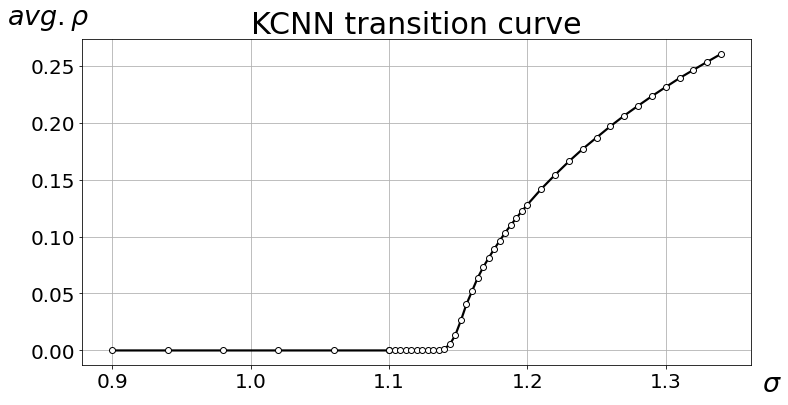

In [11]:
'''test banch for n = 20'''
# test_banch = [(i / 25) + 1.65 for i in range(6)]
# for i in range(25):
#     test_banch.append(i/250 + 1.85)
# for i in range(15):
#     test_banch.append(i/100 + 1.95)

'''test banch for n = 2'''
test_banch = [(i / 25) + 0.9 for i in range(6)]
for i in range(25):
    test_banch.append(i/250 + 1.1)
for i in range(15):
    test_banch.append(i/100 + 1.2)
    
fig, ax = plt.subplots(figsize=(12, 6))
for N in range(1):
    # ax.plot(test_banch[0:],ensemble_result_n20[N][0:], linewidth=2.2, linestyle='-', marker = 'o'\
    #         , mfc='w', color='darkviolet')    
    ax.plot(test_banch[0:],ensemble_result_n2[N][0:], linewidth=2.2, linestyle='-', marker = 'o'\
            , mfc='w', color='black')

ax.set_xlabel('$\sigma$',fontsize=27)
ax.set_ylabel('$avg.\\rho$',fontsize=27, rotation=0)
ax.set_title('KCNN transition curve',fontsize=30) #(L = 512, n = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.yaxis.set_label_coords(-0.05,1.02)
ax.xaxis.set_label_coords(1.03,-0.02)

font_prop = font_manager.FontProperties(size=18)

plt.grid()